In [89]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.datasets import CelebA
from torchvision import transforms
from tqdm import tqdm
import torchvision.transforms.functional as TF

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
# Dataloader (you can mess with batch size)
BATCH_SIZE = 128

# How many runs through the data should we do?
NO_EPOCHS = 100

# How time steps for scheduler?
TIME_STEPS = 300

# Noise Variance
BETAS = torch.linspace(0.0001, 0.02, TIME_STEPS)

# Transformations
transform_pipelines = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),  # (3,W,H)
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)


undo_transform_pipelines = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(
            lambda t: (t * 255.0).numpy().astype(np.uint8)
        ),  # Scale data between [0.,255.]
    ]
)

In [111]:
def load_data(dataset_name="CIFAR10", batch_size=16, transform=None):
    dataset_mapping = {
        "CIFAR10": {"class": CIFAR10, "root": "./data"},
        "CelebA": {"class": CelebA, "root": "./data"},
    }

    dataset_info = dataset_mapping[dataset_name]
    dataset_class = dataset_info["class"]
    dataset_root = dataset_info["root"]

    dataset = dataset_class(root=dataset_root, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    images, labels = next(iter(dataloader))

    return images, labels

In [112]:
def noise_scheduler(
    x_0: torch.tensor, t: torch.tensor, betas: torch.tensor, device: str
):
    noise = torch.randn(size=x_0.shape)

    alpha_hats = torch.cumprod(1 - betas, axis=0)

    selected_alpha_hats = alpha_hats[t]
    selected_alpha_hats = selected_alpha_hats.reshape(shape=(t.shape[0], 1, 1, 1))

    mean = torch.sqrt(selected_alpha_hats) * x_0
    variance = torch.sqrt(1.0 - selected_alpha_hats) * noise

    x_ts = mean + variance

    return x_ts.to(device), noise.to(device)

In [113]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# Implementation inspired by Aladdin Persson - PyTorch Image Segmentation Tutorial with U-NET: everything from scratch baby
class BasicUnet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        features=[64, 128, 256, 512],
    ):
        # UNET Convolution
        super(BasicUnet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

            # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)

        return x

In [126]:
# Google-Drive Error: Follow link to manually download CelebA dataset https://github.com/pytorch/vision/issues/2262#issuecomment-1235752527
# images, labels = load_data(dataset_name='CelebA', batch_size=8, transform=transform_pipelines)
images, labels = load_data(
    dataset_name="CIFAR10", batch_size=8, transform=transform_pipelines
)

Files already downloaded and verified


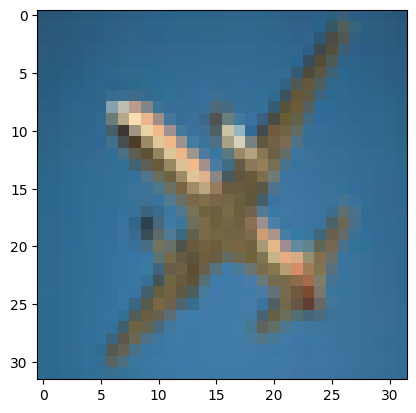

In [127]:
plt.imshow(undo_transform_pipelines(images[0]))

In [128]:
def display_noisy_images(img, nrow=3):
    _, ax = plt.subplots(nrow, 4, figsize=(8, 8))

    for j in range(nrow):
        images_to_display = img[j].permute(1, 2, 0)
        images_to_display = images_to_display / 2 + 0.5  # unnormalize

        # Display the original image without noise
        ax[j, 0].imshow(images_to_display)
        ax[j, 0].axis("off")

        # List to store tuples (noisy_image, noise_level)
        noisy_images = []

        for i in range(1, 4):
            t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,)).long()
            noisy_image, _ = noise_scheduler(
                images_to_display, t=t, betas=BETAS, device=device
            )

            # Keep track of respective noise level
            noise_level = BETAS[t[0]].item()
            noisy_images.append((noisy_image[0], noise_level))

        # Sort the list based on noise level
        noisy_images.sort(key=lambda x: x[1])

        # Display the noisy images
        for i, (noisy_image, noise_level) in enumerate(noisy_images, start=1):
            ax[j, i].imshow(torch.clamp(noisy_image.cpu(), -1.0, 1.0))
            ax[j, i].axis("off")

    plt.show()


# display_noisy_images(images, nrow=3)

 50%|█████     | 50/100 [00:13<00:14,  3.48it/s]

Finished epoch 49. Average loss for this epoch: 0.057337


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]

Finished epoch 99. Average loss for this epoch: 0.056145


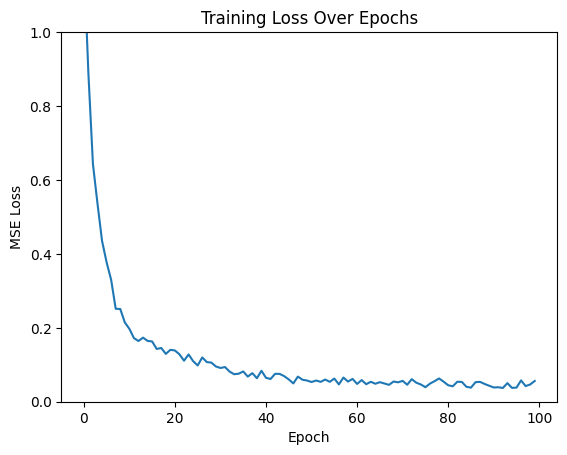

In [129]:
# SINGLE IMAGE TRAINING
img = images[0]

# Create the network
model = CNN_with_Unet()
model.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in tqdm(range(NO_EPOCHS)):
    img_batch = torch.stack([img] * BATCH_SIZE)
    t = torch.randint(0, TIME_STEPS, (BATCH_SIZE,)).long()

    img_batch_noisy, noise_batch = noise_scheduler(
        x_0=img_batch, t=t, betas=BETAS, device=device
    )

    predicted_noise_batch = model(img_batch_noisy)

    loss = loss_fn(predicted_noise_batch, noise_batch)
    batch_loss = loss.item()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(batch_loss)

    # Print our the average of the loss values for this epoch:
    if (epoch + 1) % 50 == 0:
        print(f"Finished epoch {epoch}. Average loss for this epoch: {batch_loss:05f}")


# View the loss curve
plt.plot(losses)
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")

# Save the plot to the specified location
save_location = "./data/output/training_loss_plot.png"
plt.savefig(save_location)

# Show the plot
plt.show()

<Figure size 3000x3000 with 0 Axes>

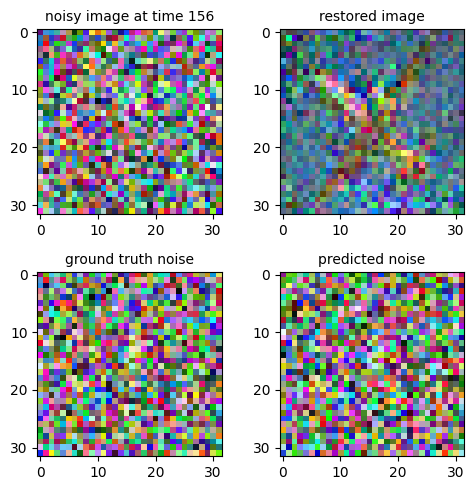

In [132]:
t = torch.randint(0, TIME_STEPS, (1,)).long()
img_noisy, noise = noise_scheduler(x_0=img, t=t, betas=BETAS, device=device)

with torch.no_grad():
    predicted_noise = model(img_noisy[0].unsqueeze(0))

    predicted_noise = predicted_noise.cpu().squeeze()
    noise = noise.cpu()

    img_n = img_noisy[0].cpu()

    restored_img = img_n - predicted_noise
    restored_img = torch.clamp(restored_img, -1.0, 1.0).squeeze()

    plt.figure(figsize=(30, 30))
    f, ax = plt.subplots(2, 2, figsize=(5, 5))

    ax[0, 0].imshow(undo_transform_pipelines(img_n))
    ax[0, 0].set_title(f"noisy image at time {t[0]}", fontsize=10)
    ax[0, 1].imshow(undo_transform_pipelines(restored_img))
    ax[0, 1].set_title(f"restored image", fontsize=10)

    ax[1, 0].imshow(undo_transform_pipelines(noise))
    ax[1, 0].set_title(f"ground truth noise", fontsize=10)
    ax[1, 1].imshow(undo_transform_pipelines(predicted_noise))
    ax[1, 1].set_title(f"predicted noise", fontsize=10)

    f.tight_layout()
    plt.show()